In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
#from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns


import sys
import importlib
sys.path.append('../../helpers/')
import helper
sys.path.append('../../model/')
from ourModel import Classifier, train, test

In [23]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# Prepare Dataset 

In [24]:
importlib.reload(helper)
path_to_data = '../../datasets/ddos/01-12/'
samples_per_file = 10
df = helper.get_ddos_data_cleaned(path = path_to_data, num_rows = samples_per_file)
df.rename(columns={'Label':'Attack Type'}, inplace=True)
df.rename(columns={' Protocol':'Protocol'}, inplace=True)
#removes 0 in protocol rows this should not be done if not classifying on protocol
df = df[df['Protocol'] != 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 9
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Protocol                      105 non-null    int64  
 1    Flow Duration                105 non-null    int64  
 2    Total Fwd Packets            105 non-null    int64  
 3    Total Backward Packets       105 non-null    int64  
 4   Total Length of Fwd Packets   105 non-null    float64
 5    Total Length of Bwd Packets  105 non-null    float64
 6    Fwd Packet Length Max        105 non-null    float64
 7    Fwd Packet Length Min        105 non-null    float64
 8    Fwd Packet Length Mean       105 non-null    float64
 9    Fwd Packet Length Std        105 non-null    float64
 10  Bwd Packet Length Max         105 non-null    float64
 11   Bwd Packet Length Min        105 non-null    float64
 12   Bwd Packet Length Mean       105 non-null    float64
 13   Bwd Pa

### Understanding ddos dataset & CIC flowmeter
Protocol: 17-UDP 6-TCP 0-Other/Unknown  
Flow Duration: measured in microseconds

In [25]:
targets = [
    'Attack Type',
      'Protocol'
]

# print(df.shape)
# print(df.dtypes.value_counts())
# for x in targets:
#     print(df[x].value_counts())


In [26]:
# encode the labels of the targets and create decoding dict
label_encoders = []
encoded_to_labels = []
for x in range(len(targets)):
    label_encoders.append(LabelEncoder())
    df[targets[x]] = label_encoders[x].fit_transform(df[targets[x]])
    encoded_to_labels.append({encoded: label for label, encoded in zip(label_encoders[x].classes_, label_encoders[x].transform(label_encoders[x].classes_))})



In [27]:
print(encoded_to_labels)

[{0: 'BENIGN', 1: 'DNS', 2: 'LDAP', 3: 'MSSQL', 4: 'NTP', 5: 'NetBIOS', 6: 'SNMP', 7: 'SSDP', 8: 'Syn', 9: 'TFTP', 10: 'UDP', 11: 'UDP-lag'}, {0: 6, 1: 17}]


# Beyond here you dont have to mess with the dataframe anymore.

### Structure data for pytorch and split into training and testing splits

In [28]:
# dataset wrapper for the dataframe. Just a way to structure the data that pytorch likes and needs to then wrap with dataloader.

class DatasetWrapper(Dataset):
    def __init__(self, df : pd.DataFrame, target : str):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=targets)).astype(np.float32)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
exp_dataset = DatasetWrapper(df, target=targets) # UPDATE for your experiments

# Split training and testing samples
train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 256 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 84, Test length: 21


## Model instantiation

In [29]:
num_features =  len(train_dataset[0][0])
num_targets =   len(train_dataset[0][1])
classes_per_target = [len(df[t].unique()) for t in targets ]

print(f"Features: {num_features}")
print(f"Targets: {num_targets}")
print(f"Classes per Target: {classes_per_target}")

Features: 66
Targets: 2
Classes per Target: [12, 2]


In [30]:
#Updated with f1
model = Classifier(n_features=num_features, 
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=2, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model


## Loss functions

In [31]:
loss_functions = []
#This loop could easily be adapted to us BinaryCrossEntropy for binary class and Cross for multi class
for x in targets:
    loss_functions.append(nn.CrossEntropyLoss())

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


## Train Test Loop

In [32]:
epochs = 40 #Set the number of epochs

In [33]:
train_losses = []
test_losses = []
train_accuracies = [[] for _ in range(num_targets)]
test_accuracies =  [[] for _ in range(num_targets)]

for t in range(epochs):
  train_loss, train_accuracy= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, all_predictions, all_targets, f1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  #Losses
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  #Accuracies
  for i in range(num_targets):
    train_accuracies[i].append(train_accuracy[i])
    test_accuracies[i].append(test_accuracy[i])
 
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"

  train_metrics = f"Train: Loss {train_loss:.2f}"
  for target, Acc in zip(targets, train_accuracy):
    train_metrics += f", {target} Accuracy: {Acc:.2f}"
  
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Attack Type Accuracy {format_metric(test_accuracy[0])}, Attack F1 {format_metric(f1[0])}"
  for target, Acc, fone in zip(targets, test_accuracy, f1):
    test_metrics += f", {target} Accuracy: {Acc:.2f}, {target} F1: {fone:.2f}"

  print(f"{epoch_str:15} | {train_metrics} | {test_metrics}")


Epoch [ 1/40]   | Train: Loss 1.64, Attack Type Accuracy: 0.10, Protocol Accuracy: 0.25 | Test: Loss 1.61, Attack Type Accuracy 0.05, Attack F1 0.00, Attack Type Accuracy: 0.05, Attack Type F1: 0.00, Protocol Accuracy: 0.57, Protocol F1: 0.56
Epoch [ 2/40]   | Train: Loss 1.62, Attack Type Accuracy: 0.10, Protocol Accuracy: 0.32 | Test: Loss 1.60, Attack Type Accuracy 0.05, Attack F1 0.00, Attack Type Accuracy: 0.05, Attack Type F1: 0.00, Protocol Accuracy: 0.62, Protocol F1: 0.47
Epoch [ 3/40]   | Train: Loss 1.60, Attack Type Accuracy: 0.10, Protocol Accuracy: 0.75 | Test: Loss 1.60, Attack Type Accuracy 0.05, Attack F1 0.00, Attack Type Accuracy: 0.05, Attack Type F1: 0.00, Protocol Accuracy: 0.62, Protocol F1: 0.47
Epoch [ 4/40]   | Train: Loss 1.58, Attack Type Accuracy: 0.10, Protocol Accuracy: 0.75 | Test: Loss 1.59, Attack Type Accuracy 0.05, Attack F1 0.00, Attack Type Accuracy: 0.05, Attack Type F1: 0.00, Protocol Accuracy: 0.62, Protocol F1: 0.47
Epoch [ 5/40]   | Train: Los

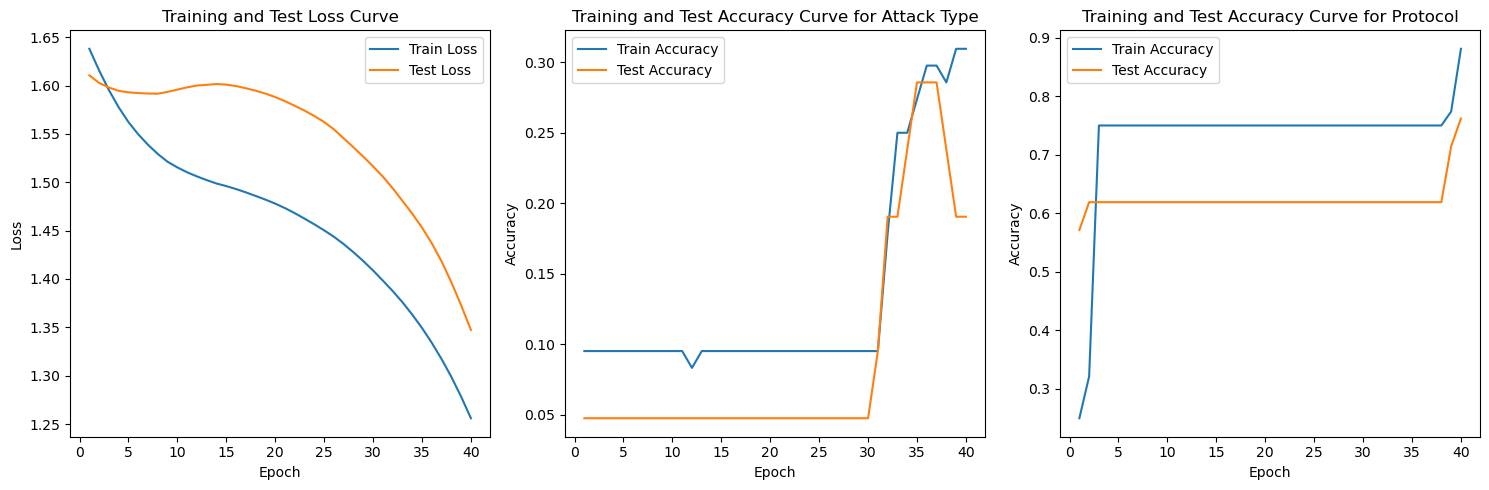

In [34]:
plot_num = 1
# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, plot_num)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plot_num+=1

for i in range(num_targets):
    plt.subplot(1, 3, plot_num)
    plt.plot(range(1, epochs+1), train_accuracies[i], label='Train Accuracy')
    plt.plot(range(1, epochs+1), test_accuracies[i], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy Curve for {targets[i]}')
    plt.legend()
    plot_num+=1


plt.tight_layout()
plt.tight_layout()
plt.show()


In [17]:
# actual_labels = [encoded_to_labels[i] for i in sorted(list(set(all_targets[i] + all_predictions[i])))]
# conf_matrix_1 = confusion_matrix(all_targets[i], all_predictions[i])
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=actual_labels, yticklabels=actual_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix for {targets[0]}')
# plt.show()